notebook to plot boundary conditions from `NT_BC` and compare to Geant simulations

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
def plottable(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]

def plottable_spectrum(X, Y):
    return (X[1:] + X[:-1])/2, Y[1:]/abs(X[1:] - X[:-1])

In [29]:
ss_data_file = 'data/V1/phi_calcs.dat'
ss_dat = pd.read_csv(ss_data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

Eg_s = ss_dat.Eg.values
phig_s = ss_dat.phig.values
gs_s = ss_dat.index

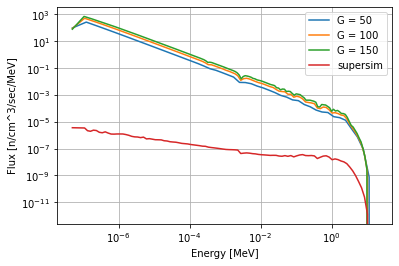

In [30]:
plt.figure()
plt.loglog()
plt.grid()
plt.xlabel('Energy [MeV]')
plt.ylabel('Flux [n/cm^3/sec/MeV]')

for G in [50, 100, 150]:
    data_file = f'data/V1/data_Norite_{G}_BC_V1.dat'
    dat = pd.read_csv(data_file, sep = ' ', index_col = 0, names = ['Eg','phig'])

    Eg = dat.Eg.values
    phig = dat.phig.values
    gs = dat.index

    plt.plot(*plottable_spectrum(Eg, phig), label = f'G = {G}')
plt.plot(*plottable_spectrum(Eg_s, phig_s), label = 'supersim')
#plt.plot(Eg[:-1], (1e-11)/Eg[:-1], label = '1/E')

plt.legend()